<a href="https://colab.research.google.com/github/BMKEITA/adversarial_firewall/blob/main/extendadversarialfirewallmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Epoch 1 - Train: 98.05%, Val: 97.93%, Loss: 0.2135
Epoch 2 - Train: 98.82%, Val: 98.43%, Loss: 0.0536
Epoch 3 - Train: 99.35%, Val: 98.91%, Loss: 0.0373
Epoch 4 - Train: 99.41%, Val: 98.99%, Loss: 0.0270
Epoch 5 - Train: 99.56%, Val: 98.97%, Loss: 0.0206
Epoch 6 - Train: 99.59%, Val: 99.02%, Loss: 0.0178
Epoch 7 - Train: 99.71%, Val: 98.98%, Loss: 0.0135
Epoch 8 - Train: 99.81%, Val: 99.13%, Loss: 0.0106
Epoch 9 - Train: 99.61%, Val: 98.89%, Loss: 0.0111
Epoch 10 - Train: 99.79%, Val: 99.02%, Loss: 0.0091
Epoch 11 - Train: 99.67%, Val: 98.93%, Loss: 0.0073
Epoch 12 - Train: 99.81%, Val: 99.06%, Loss: 0.0073
Epoch 13 - Train: 99.67%, Val: 98.98%, Loss: 0.0055
Epoch 14 - Train: 99.88%, Val: 99.19%, Loss: 0.0059
Epoch 15 - Train: 99.85%, Val: 98.97%, Loss: 0.0053
Epoch 16 - Train: 99.87%, Val: 99.08%, Loss: 0.0047
Epoch 17 - Train: 99.79%, Val: 98.99%, Loss: 0.0027
Epoch 18 - Train: 99.63%, Val: 98.87%, Loss: 0.0046
Epoch 19 - Train: 99.87%, Val: 99.21%, Loss: 0.0042
Epo

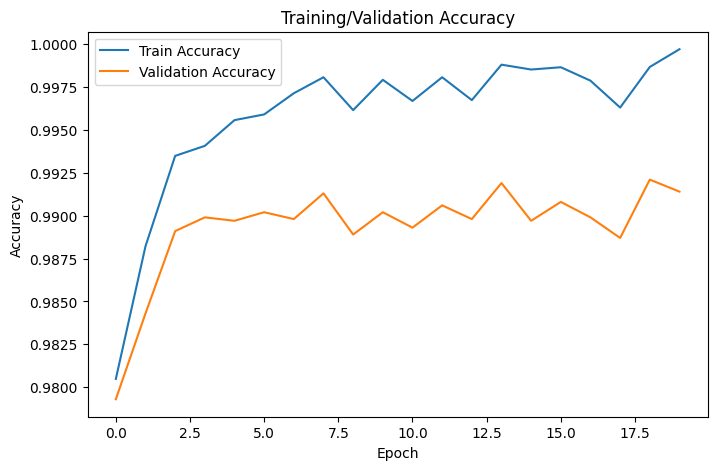

[Firewall] Epoch 1 - Loss: 0.3655
[Firewall] Epoch 2 - Loss: 0.0653
[Firewall] Epoch 3 - Loss: 0.0297
[Firewall] Epoch 4 - Loss: 0.0214
[Firewall] Epoch 5 - Loss: 0.0212
✅ Firewall model saved!

Classification Report:
              precision    recall  f1-score   support

       Clean       0.94      1.00      0.97      6400
        FGSM       1.00      0.99      1.00      6400
         PGD       0.99      1.00      1.00      6400
    DeepFool       1.00      0.93      0.97      6400
       Patch       1.00      1.00      1.00      6400

    accuracy                           0.99     32000
   macro avg       0.99      0.99      0.99     32000
weighted avg       0.99      0.99      0.99     32000



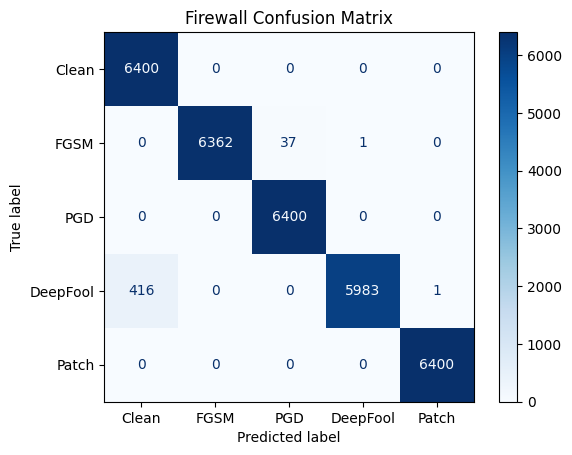

Log saved to: /content/drive/MyDrive/adversarial_firewall_mnist/firewall_predictions.csv


In [ ]:
# Install required packages
!pip install -q torchattacks scikit-learn pandas matplotlib

# === Imports ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as T
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torchattacks import FGSM, PGD, DeepFool

# === Device Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Paths ===
base_path = "/content/drive/MyDrive/adversarial_firewall_mnist"
os.makedirs(base_path, exist_ok=True)

# === MNIST Dataset (Expanded to 3 channels) ===
transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: x.expand(3, -1, -1))  # Convert 1x28x28 → 3x28x28
])
trainset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
testset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

# === Base Model ===
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

base_model = SimpleCNN().to(device)

# === Accuracy and Training ===
def evaluate_accuracy(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

train_accs, val_accs = [], []
def train_base_model(model, loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(20):
        model.train()
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = F.cross_entropy(model(x), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_acc = evaluate_accuracy(model, trainloader)
        val_acc = evaluate_accuracy(model, testloader)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1} - Train: {train_acc:.2%}, Val: {val_acc:.2%}, Loss: {total_loss/len(loader):.4f}")

train_base_model(base_model, trainloader)
torch.save(base_model.state_dict(), f"{base_path}/base_model.pth")

# === Plot Accuracy Curve ===
def plot_training_accuracy_curve(train_accs, val_accs, save_path=None):
    plt.figure(figsize=(8, 5))
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training/Validation Accuracy")
    plt.legend()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

plot_training_accuracy_curve(train_accs, val_accs, save_path=f"{base_path}/accuracy_curve.png")

# === Patch Attack ===
def add_patch(images, patch_size=5, position=(23, 23), intensity=1.0):
    patched = images.clone()
    x, y = position
    patched[:, :, x:x+patch_size, y:y+patch_size] = intensity
    return patched

# === Create Firewall Dataset ===
def create_firewall_dataset(model, loader, batches=50):
    model.eval()
    fgsm = FGSM(model, eps=0.2)
    pgd = PGD(model, eps=0.3, alpha=0.01, steps=10)
    deepfool = DeepFool(model, steps=50)
    data = []

    for i, (x, y) in enumerate(loader):
        if i >= batches: break
        x, y = x.to(device), y.to(device)
        data.append((x.clone(), torch.zeros(len(x), dtype=torch.long)))  # Clean
        data.append((fgsm(x, y), torch.full((len(x),), 1)))              # FGSM
        data.append((pgd(x, y), torch.full((len(x),), 2)))               # PGD
        data.append((deepfool(x, y), torch.full((len(x),), 3)))          # DeepFool
        data.append((add_patch(x), torch.full((len(x),), 4)))            # Patch

    X = torch.cat([d[0].cpu() for d in data])
    y = torch.cat([d[1] for d in data])
    return X, y

X_fw, y_fw = create_firewall_dataset(base_model, trainloader)

# === Firewall Model ===
class FirewallNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 5)  # 5 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

firewall = FirewallNet().to(device)

# === Train Firewall ===
def train_firewall_model(model, X, y):
    model.train()
    loader = DataLoader(TensorDataset(X, y), batch_size=256, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(5):
        total_loss = 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = F.cross_entropy(model(xb), yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[Firewall] Epoch {epoch+1} - Loss: {total_loss/len(loader):.4f}")

train_firewall_model(firewall, X_fw, y_fw)

torch.save(firewall.state_dict(), f"{base_path}/firewall_model.pth")
print("✅ Firewall model saved!")

# === Evaluation ===
def evaluate_firewall(model, X, y, class_names, output_dir):
    model.eval()
    loader = DataLoader(TensorDataset(X, y), batch_size=256)
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            preds = model(xb.to(device)).argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.numpy())

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues")
    plt.title("Firewall Confusion Matrix")
    plt.savefig(f"{output_dir}/conf_matrix.png", dpi=300)
    plt.show()

    # Save predictions
    pd.DataFrame({
        "TrueLabel": [class_names[i] for i in all_labels],
        "Predicted": [class_names[i] for i in all_preds]
    }).to_csv(f"{output_dir}/firewall_predictions.csv", index=False)
    print(f"Log saved to: {output_dir}/firewall_predictions.csv")

# === Run Evaluation
class_names = ["Clean", "FGSM", "PGD", "DeepFool", "Patch"]
evaluate_firewall(firewall, X_fw, y_fw, class_names, output_dir=base_path)
